In [167]:
from aeon.datasets import load_classification
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn_extra.cluster import KMedoids
from scipy.optimize import minimize
from fastdtw import fastdtw
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics.cluster import rand_score

In [158]:
X, y = load_classification("Coffee")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [159]:
X_train = X_train.reshape(X_train.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

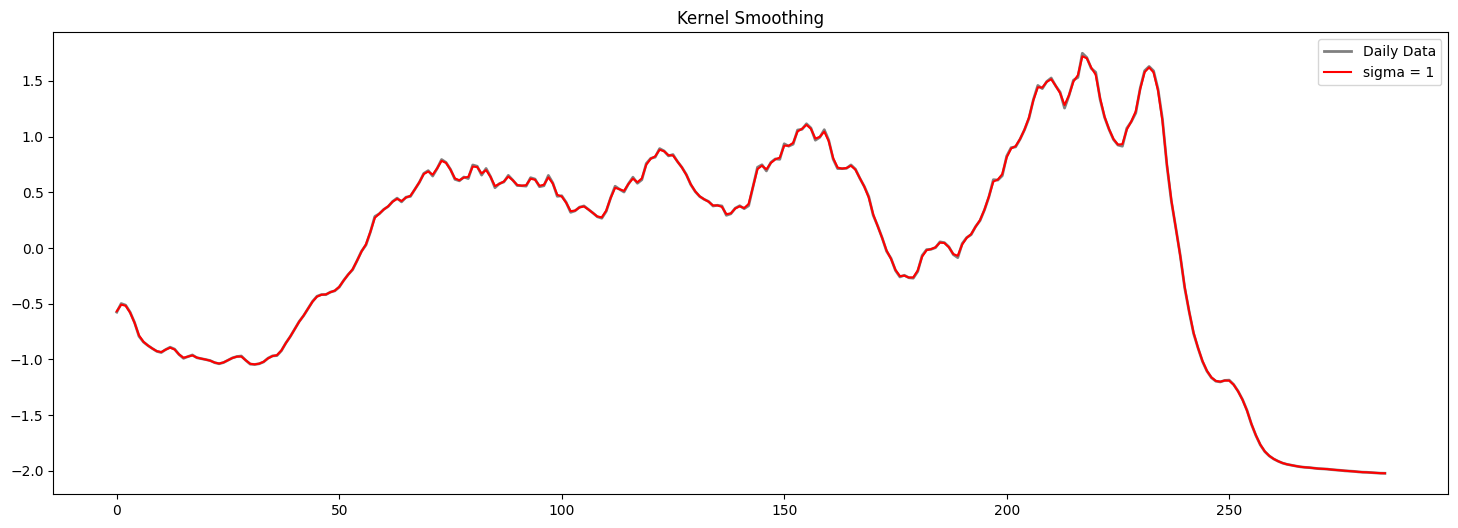

In [228]:
fig, ax = plt.subplots(figsize=(18, 6))

ax.plot(
    X_train[0],
    linestyle="-",
    linewidth=2,
    label="Daily Data",
    color="grey",
)

ax.plot(
    gaussian_filter1d(X_train[0], 0.5),
    color="red",
    markersize=1,
    linestyle="-",
    label="sigma = 1",
)


ax.set_title("Kernel Smoothing")
ax.legend()

In [248]:
def smooth(X, bandwidth):
    #smoother = KernelSmoother(NadarayaWatsonHatMatrix(bandwidth=bandwidth))
    X_smooth = np.zeros(X.shape)
    for i in range(X.shape[0]):
        #ts = FDataGrid(X[i])
        #X_smooth[i] = smoother.fit_transform(ts).data_matrix.reshape(X.shape[1])
        X_smooth[i] = gaussian_filter1d(X[i], bandwidth)
    return X_smooth

def get_dissimilarity_matrix(X):
    dissimilarity_matrix = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            dissimilarity_matrix[i, j], _ = fastdtw(X[i], X[j], dist=2)
            #dissimilarity_matrix[i, j] = np.linalg.norm(X[i] - X[j])
    return dissimilarity_matrix

def kernel_clustering(X, lmbda, n_clusters):
    X_smooth = smooth(X, lmbda)
    dissimilarity_matrix = get_dissimilarity_matrix(X_smooth)
    kmedoids = KMedoids(n_clusters=n_clusters, metric="precomputed", random_state=42)
    kmedoids.fit(dissimilarity_matrix)
    return kmedoids.inertia_ + abs(lmbda), kmedoids.labels_, kmedoids

def optimize_lambda(X, n_clusters):
    def objective(lmbda):
        return kernel_clustering(X, lmbda, n_clusters)[0]
    
    initial_lambda = 1.0
    bounds = [(0.05, 100.0)]

    result = minimize(objective, initial_lambda, method='Nelder-Mead', bounds=bounds)
    
    return result.x[0], result.fun

DTW

In [162]:
optimal_lambda, optimal_loss = optimize_lambda(X_train, 2)

In [176]:
optimal_lambda

0.05

In [171]:
loss, clustering, centers = kernel_clustering(X_train, optimal_lambda, 2)

In [173]:
y_train = y_train.reshape(-1)
rand_score(clustering, y_train)

0.9112050739957717

In [174]:
loss_test, clustering_test, centers_test = kernel_clustering(X_test, optimal_lambda, 2)
rand_score(clustering_test, y_test.reshape(-1))

0.5151515151515151

Euclidean

In [ ]:
optimal_lambda, optimal_loss = optimize_lambda(X_train, 2)

In [255]:
loss, clustering, kmedoids = kernel_clustering(X_train, 1, 2)

In [ ]:
y_train = y_train.reshape(-1)
rand_score(clustering, y_train)

0.8699788583509513

In [252]:
kmedoids.predict(get_dissimilarity_matrix(X_test))

In [253]:
y_test = y_test.reshape(-1)
rand_score(clustering_test, y_test)

0.5151515151515151